# Are statin prescribing ratios different for dispensing practices?

#### 1. Obtain GP Prescribing data
#### 2. Cut GP Prescribing data for things of interest (statins)
#### 3. Obtain list of dispensing practices
#### 3a. Add codes to list of dispensing practices (name and address only is provided)
#### 4. Combine statin cut and dispensing practice list
#### 5. Compare dispensing vs non-dispensing statin prescribing ratios

In [1]:
import requests
from StringIO import StringIO
from numpy import nan as NA
import pandas as pd
import zipfile
import re
%matplotlib inline
import matplotlib.pyplot as plt
import xlrd
import statsmodels.api as sm
from patsy import dmatrices, dmatrix
import scipy as scipy

In [2]:
def fetch_prescribing_data():
    url = 'http://datagov.ic.nhs.uk/presentation/2015_01_January/T201501PDPI+BNFT.CSV' #gp prescribing data (Jan 2015)
    r = requests.get(url)
    data = r.content
    df = (pd.read_csv(StringIO(data)))
    df.to_csv('datas/T201501PDPI+BNFT.CSV')

def fetch_dispensary_data():
    url = 'http://systems.hscic.gov.uk/data/ods/datadownloads/data-files/edispensary.zip'
    r = requests.get(url)
    z = zipfile.ZipFile(StringIO(r.content))
    df = pd.read_csv(z.open('edispensary.csv'))
    df.to_csv('datas/edispensary.csv')

def fetch_gp_details():
    url = 'http://systems.hscic.gov.uk/data/ods/datadownloads/data-files/epraccur.zip'
    r = requests.get(url)
    z = zipfile.ZipFile(StringIO(r.content))
    df = pd.read_csv(z.open('epraccur.csv'))
    df.to_csv('datas/epraccur.csv')

def clean_prescribing_data(df):
    df.columns = [x.strip() for x in df.columns] #gets rid of variable whitespace
    df = df[df['BNF NAME'].str.contains('statin')] #cut for rows with statin in them
    df = df[~df['BNF NAME'].str.contains('Nystatin|Sandostatin|Ecostatin')] #throw away unwanted statins
    df.to_csv('datas/StatinsJan2015.csv') #save the result
    return(df)

def clean_dispensing_practice_addresses(dpad):
    dpad = dpad['Dispensing Practices Address Details'].dropna()
    dpad = dpad.reset_index()
    del dpad['index']
    dpad['Dispensing Practices Address Details'] = dpad['Dispensing Practices Address Details'].str.strip()
    dpad['Dispensing Practices Address Details'] = dpad['Dispensing Practices Address Details'].str.replace('\n', ' ')
    dpad['NAME'] = dpad['Dispensing Practices Address Details'].str.split(',').str[0].str.upper()
    dpad['POSTCODE'] = dpad['Dispensing Practices Address Details'].str.split(',').str[-1].astype(str).str.strip()
    dpad.ix[254,2] = 'BN25 1HH' #one practice lacked a postcode.... we fix this manually
    dpad.ix[254,1] = 'Old School Surgery'
    return(dpad)

def validate_dispensing_postcodes():
    assert(len(dpad[~dpad.Postcode.str.contains(r'[A-Z]{1,2}[0-9R][0-9A-Z]? [0-9][A-Z]{2}')]) == 0) #length of dataframe of postcodes that don't pass regex should be 0 

#nb df = pd.read_csv('http://datagov.ic.nhs.uk/presentation/2015_01_January/T201501PDPI+BNFT.CSV') should also work but seems slower

In [3]:
#df = fetch_prescribing_data() #commented because requires internet and is slow 
#df = clean_prescribing_data(df) #commented because need only run once and is slow
#dispdata = fetch_dispensary_data() #doesn't actually contain dispensing practices
#fetch_gp_details()

df = pd.read_csv('datas/StatinsJan2015.csv') #load cleaned prescribing data cut
gpdetail = pd.read_csv('datas/epraccur.csv') #from http://systems.hscic.gov.uk/data/ods/datadownloads/data-files/epraccur.zip

dpad_formatting_junk = ['Dispensing Practices Address Details', 'Primary Care Trust:', 'Report For:', 'Practice Name and Address', 'January 2015']
dpad = pd.read_excel('datas/Disp Pracs Name and Address 2015-01-31.xls', usecols=[0], na_values=dpad_formatting_junk) #load dispensing practice list

dpad = clean_dispensing_practice_addresses(dpad)

gpdetail = gpdetail.icol([1,2,10,26,15]) #throw away columns we don't care about
gpdetail.columns = ['PRACTICE', 'NAME', 'POSTCODE', 'Prescribing Setting', 'CCG']

dpad = pd.merge(gpdetail, dpad, on=['NAME','POSTCODE']) #merge to add practice codes

df['DP'] = df.PRACTICE.isin(dpad.PRACTICE) #add column DP to identify Dispensing Practices

df['IR'] = df['BNF NAME'].str.contains('Rosuvastatin') #add column for Is Rosuvastatin

In [4]:
df = pd.merge(df, gpdetail, on='PRACTICE')

In [5]:
df.head()

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1,SHA,PCT,PRACTICE,BNF CODE,BNF NAME,ITEMS,NIC,ACT COST,QUANTITY,PERIOD,Unnamed: 11,DP,IR,NAME,POSTCODE,Prescribing Setting,CCG
0,0,586,586,Q44,RY7,N85638,0212000B0AAACAC,Atorvastatin_Tab 40mg,2,0.58,0.76,10,201501,,False,False,GP APH OOH,CH49 5PE,2,12F
1,1,1310,1310,Q44,RY7,Y03836,0212000B0AAACAC,Atorvastatin_Tab 40mg,1,1.62,1.51,28,201501,,False,False,WIRRAL COMMUNITY NMP,CH41 5AL,9,12F
2,2,2050,2050,Q44,01C,N81002,0212000AAAAAAAA,Rosuvastatin Calc_Tab 10mg,14,360.60,332.98,560,201501,,False,True,KENMORE MEDICAL CENTRE,SK9 1PA,4,01C
3,3,2051,2051,Q44,01C,N81002,0212000AAAAABAB,Rosuvastatin Calc_Tab 20mg,4,208.16,192.16,224,201501,,False,True,KENMORE MEDICAL CENTRE,SK9 1PA,4,01C
4,4,2052,2052,Q44,01C,N81002,0212000AAAAADAD,Rosuvastatin Calc_Tab 5mg,5,180.30,166.47,280,201501,,False,True,KENMORE MEDICAL CENTRE,SK9 1PA,4,01C


In [6]:
df1 = df.groupby(['DP','PRACTICE', 'IR']).ITEMS.sum()


In [7]:
df1.head() #what the datas look like

DP     PRACTICE  IR   
False  A81001    False     175
                 True        8
       A81002    False    1041
                 True       63
       A81003    False     256
Name: ITEMS, dtype: int64

In [8]:
df1 = df1.unstack()
df1 = df1.reset_index()
df1 = df1.fillna(0.0) #applying groupby when there are no items in a category generates NaNs where we would instead prefer 0's


In [9]:
df1.columns = ['DP', 'PRACTICE', 'False_IR', 'True_IR']

In [10]:
df1['Proportion'] = (df1['True_IR'] / (df1['True_IR'] + df1['False_IR']))

In [11]:
df1.head() #what the datas look like

,DP,PRACTICE,False_IR,True_IR,Proportion
0,False,A81001,175,8,0.043716
1,False,A81002,1041,63,0.057065
2,False,A81003,256,2,0.007752
3,False,A81004,386,14,0.035000
4,False,A81005,389,17,0.041872


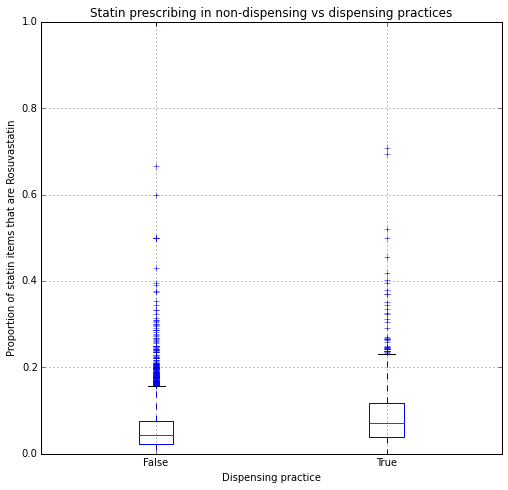

In [12]:
df1[['DP', 'Proportion']].boxplot(by='DP', figsize=(8,8))
plt.title("Statin prescribing in non-dispensing vs dispensing practices")
plt.suptitle("")
#plt.ylim((0,100))
plt.ylabel('Proportion of statin items that are Rosuvastatin')
plt.xlabel('Dispensing practice')

In [13]:
df1[df1['DP'] == False].Proportion.skew()

6.6462513063644311

In [14]:
df1[df1['DP'] == True].Proportion.skew()

2.6161450391185763

In [15]:
df1[df1['DP'] == False].Proportion.var()

0.0038505026248185823

In [16]:
df1[df1['DP'] == True].Proportion.var()

0.0054300478176196095

In [17]:
df1[df1['DP'] == False].Proportion.median()

0.0440251572327044

In [18]:
df1[df1['DP'] == True].Proportion.median()

0.0706525978005326

In [19]:
df1[df1['DP'] == False].Proportion.describe()

count    7108.000000
mean        0.056663
std         0.062052
min         0.000000
25%         0.021583
50%         0.044025
75%         0.076336
max         1.000000
Name: Proportion, dtype: float64

In [20]:
df1[df1['DP'] == True].Proportion.describe()

count    1016.000000
mean        0.088176
std         0.073689
min         0.000000
25%         0.038829
50%         0.070653
75%         0.116599
max         0.707071
Name: Proportion, dtype: float64

In [21]:
df1[df1['Proportion'] > 0.5].sort(columns='Proportion', ascending=False).head()

,DP,PRACTICE,False_IR,True_IR,Proportion
1091,False,C83656,0,1,1
6564,False,Y00415,0,1,1
6625,False,Y00840,0,1,1
6736,False,Y02167,0,1,1
6924,False,Y02859,0,1,1


In [22]:
gpdetail[gpdetail.PRACTICE.isin(df1[df1['Proportion'] > 0.5].PRACTICE)].head()

,PRACTICE,NAME,POSTCODE,Prescribing Setting,CCG
1538,C85623,KINGSWELL SURGERY PMS PRACTICE,S36 6DY,4,02P
2372,E87694,THE ROYAL MEWS SURGERY,SW1W 0QH,4,09A
2711,G82170,LAMBERHURST,TN3 8EX,4,99J
5274,M84031,REVEL SURGERY,CV23 0LU,4,05A
5962,Y00860,SOUTH ESSEX OOH,TN24 0GP,2,99G


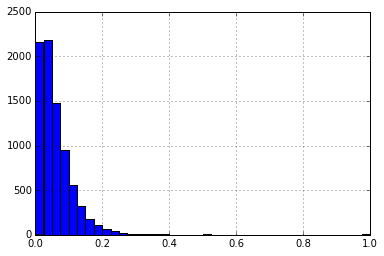

In [23]:
df1.Proportion.hist(bins=40)

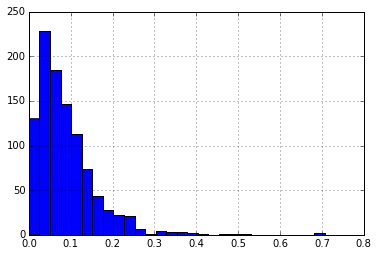

In [24]:
df1[df1['DP'] == True].Proportion.hist(bins=28)

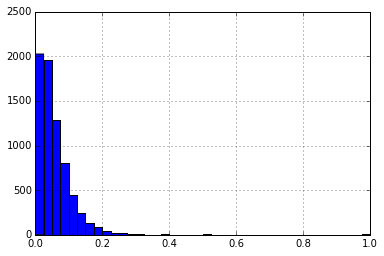

In [25]:
df1[df1['DP'] == False].Proportion.hist(bins=40)

## next steps... add ccg column and try :
## meglm proportionstupid dispensingornot || ccg:, family(binomial) link(logit) in statsmodels

In [26]:
df2 = pd.merge(df1, gpdetail, on='PRACTICE')

In [27]:
df2['Prescribing Setting'].unique() # not all practices in the gp prescribing set are gp practices. nice.

array([ 4,  8,  9,  0,  2,  1, 13, 14, 10, 12,  3])

In [45]:
df2.head()

,DP,PRACTICE,False_IR,True_IR,Proportion,NAME,POSTCODE,Prescribing Setting,CCG
0,False,A81001,175,8,0.043716,THE DENSHAM SURGERY,TS18 1HU,4,00K
1,False,A81002,1041,63,0.057065,QUEENS PARK MEDICAL CENTRE,TS18 2AW,4,00K
2,False,A81003,256,2,0.007752,THE HEALTH CENTRE,TS26 8DB,4,00K
3,False,A81004,386,14,0.035000,WOODLANDS ROAD SURGERY,TS1 3BE,4,00M
4,False,A81005,389,17,0.041872,SPRINGWOOD SURGERY,TS14 7DJ,4,00M


In [144]:
def model(df):
    
    import statsmodels.formula.api as smf
    
    #df = df[['DP', 'Proportion', 'CCG']] #get rid of extraneous stuff
        
    mod = smf.mixedlm('Proportion ~ DP', df, groups=df['CCG']) #http://statsmodels.sourceforge.net/devel/endog_exog.html
    
    res = mod.fit()

    return res

In [149]:
res = model(df2)

/home/sam/.virtualenvs/pa-research/local/lib/python2.7/site-packages/statsmodels/regression/mixed_linear_model.py:1717: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [153]:
res = model(df2)
print res.summary() 


          Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: Proportion
No. Observations: 8124    Method:             REML      
No. Groups:       209     Scale:              0.0036    
Min. group size:  6       Likelihood:         11147.1739
Max. group size:  125     Converged:          Yes       
Mean group size:  38.9                                  
--------------------------------------------------------
               Coef. Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------
Intercept      0.057    0.002 34.748 0.000  0.054  0.060
DP[T.True]     0.027    0.002 11.620 0.000  0.022  0.031
Intercept RE   0.000    0.001                           



/home/sam/.virtualenvs/pa-research/local/lib/python2.7/site-packages/statsmodels/regression/mixed_linear_model.py:1717: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


# would it make a diff if I formatted my datas like in the smf e.g? probably. try it.
# also to try is excluding non gp practices

In [125]:
ccg_codes = df.CCG.unique()
ccg_lookup = zip(list(ccg_codes), range(0,209))
ccg_lookup = dict(ccg_lookup)

In [111]:
df3 = df2[['DP', 'Proportion', 'CCG']]
df3['DP'] = df3['DP'].astype(str).str.replace('False','0').str.replace('True','1')
df3['CCG'] = df3['CCG'].map(lambda x: ccg_lookup.get(x))
df3['DP'] = df3['DP'].astype(int)
df3['CCG'] = df3['CCG'].astype(int)

In [154]:
res = model(df3)
print res.summary() 


          Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: Proportion
No. Observations: 8124    Method:             REML      
No. Groups:       209     Scale:              0.0036    
Min. group size:  6       Likelihood:         11147.1739
Max. group size:  125     Converged:          Yes       
Mean group size:  38.9                                  
--------------------------------------------------------
               Coef. Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------
Intercept      0.057    0.002 34.748 0.000  0.054  0.060
DP             0.027    0.002 11.620 0.000  0.022  0.031
Intercept RE   0.000    0.001                           



/home/sam/.virtualenvs/pa-research/local/lib/python2.7/site-packages/statsmodels/regression/mixed_linear_model.py:1717: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
